# Advanced HPP Model

## Evaluating the performance of a hybrid power plant using HyDesign

HyDesign is an open-source tool for design and optimization of utility scale wind-solar-storage based hybrid power plants.

In this notebook we will evaluate a hybrid power plant design in a specific location.

A hybrid power plant design consists on selecting the following parameters:

**Wind Turbine design:**

1. Clearance [m] (`clearance`): Height from the ground to rotor tip at lowest posstion. This parameter controls the wind turbine hub height given a rotor radius: `clearance =  HH - R`. 
2. Specific power of the wind turbine [MW/m2] (`sp`): Defined as `sp = p_rated / ( pi * R^2 )`, it controls the turbine rotor size for a given rated power. Turbines with lower specific power produce more power at lower wind speeds, but are more expensive.
3. Rated power of the wind turbine [MW] (`p_rated`)

**Wind Plant design:**

4. Number of wind turbines in the wind plant [-] (`Nwt`)
5. Wind power installation density [MW/km2] (`wind_MW_per_km2`): This parameter controls how closely spaced are the turbines, which in turns affect how much wake losses are present.

**PV Plant design:**

6. Solar plant power capacity [MW] (`solar_MW`)
7. Surface tilt [deg] (`surface_tilt`)
8. Surface azimuth [deg] (`surface_azimuth`)
9. DC-AC ratio [-] (`solar_DCAC`): This parameter controls how much over-planting of PV (in DC power) is connected to the inverters. It is common practice in PV design to have `solar_DCAC = 1.5`. 

**Battery Storage design:**

10. Battery power [MW] (`b_P`)
11. Battery energy capacity in hours [MWh] (`b_E_h `): Battery storage capacity in hours of full battery power (`b_E = b_E_h * b_P `). 
12. Cost of battery power fluctuations in peak price ratio [-] (`cost_of_batt_degr`): This parameter controls how much penalty is given to do ramps in battery power in the HPP operation.


##
**Imports**

Install hydesign if needed.
Import basic libraries. 
Import HPP model assembly class.
Import the examples file path.

In [2]:
# Install hydesign if needed

import importlib
if not importlib.util.find_spec("hydesign"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/hydesign.git    

In [3]:
import os
import time
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from hydesign.assembly.hpp_assembly import hpp_model
from hydesign.examples import examples_filepath

##
**Specifying the site**

Hydesign, provides example data from several sites in India and Europe. 

The site coordinates (longitude, latitude, and altitude) are given in `examples_sites.csv`.

In [4]:
examples_sites = pd.read_csv(f'{examples_filepath}examples_sites.csv', index_col=0, sep=';')
examples_sites
print(type(examples_sites))
print("Hey her har jeg ændret noget!")
print("Hey virker det her??")
print("Hey jeg har ændret noget igen! hilsne Ebbe ")



<class 'pandas.core.frame.DataFrame'>
Hey her har jeg ændret noget!
Hey virker det her??
Hey jeg har ændret noget igen! hilsne Ebbe 


In [4]:
name = 'Denmark_good_wind'
ex_site = examples_sites.loc[examples_sites.name == name]

longitude = ex_site['longitude'].values[0]
latitude = ex_site['latitude'].values[0]
altitude = ex_site['altitude'].values[0]

input_ts_fn = examples_filepath+ex_site['input_ts_fn'].values[0]
sim_pars_fn = examples_filepath+ex_site['sim_pars_fn'].values[0]


## 
**Initializing the HPP model**

Initialize the HPP model (hpp_model class) with the coordinates and the necessary input files.

In [5]:
hpp = hpp_model(
        latitude=latitude,
        longitude=longitude,
        altitude=altitude,
        num_batteries = 5,
        work_dir = './',
        sim_pars_fn = sim_pars_fn,
        input_ts_fn = input_ts_fn,
)


Fixed parameters on the site
-------------------------------
longitude = 8.594398
latitude = 56.227322
altitude = 85.0


##
### Evaluating the HPP model

In [6]:
start = time.time()

clearance = 10
sp = 350
p_rated = 5
Nwt = 70
wind_MW_per_km2 = 7
solar_MW = 100
surface_tilt = 50
surface_azimuth = 180
solar_DCAC = 1.5
b_P = 50
b_E_h  = 3
cost_of_batt_degr = 10

x = [clearance, sp, p_rated, Nwt, wind_MW_per_km2, \
solar_MW, surface_tilt, surface_azimuth, solar_DCAC, \
b_P, b_E_h , cost_of_batt_degr]

outs = hpp.evaluate(*x)

hpp.print_design(x, outs)

end = time.time()
print(f'exec. time [min]:', (end - start)/60 )


Design:
---------------
clearance [m]: 10.000
sp [W/m2]: 350.000
p_rated [MW]: 5.000
Nwt: 70.000
wind_MW_per_km2 [MW/km2]: 7.000
solar_MW [MW]: 100.000
surface_tilt [deg]: 50.000
surface_azimuth [deg]: 180.000
DC_AC_ratio: 1.500
b_P [MW]: 50.000
b_E_h [h]: 3.000
cost_of_battery_P_fluct_in_peak_price_ratio: 10.000


NPV_over_CAPEX: 0.207
NPV [MEuro]: 78.996
IRR: 0.078
LCOE [Euro/MWh]: 47.474
Revenues [MEuro]: 27.171
CAPEX [MEuro]: 382.218
OPEX [MEuro]: 6.040
Wind CAPEX [MEuro]: 267.506
Wind OPEX [MEuro]: 5.365
PV CAPEX [MEuro]: 33.500
PV OPEX [MEuro]: 0.675
Batt CAPEX [MEuro]: 15.230
Batt OPEX [MEuro]: 0.000
Shared CAPEX [MEuro]: 65.982
Shared OPEX [MEuro]: 0.000
penalty lifetime [MEuro]: 0.000
AEP [GWh]: 733.508
GUF: 0.279
grid [MW]: 300.000
wind [MW]: 350.000
solar [MW]: 100.000
Battery Energy [MWh]: 150.000
Battery Power [MW]: 50.000
Total curtailment [GWh]: 337.661
Total curtailment with deg [GWh]: 152.556
Awpp [km2]: 50.000
Apvp [km2]: 1.226
Plant area [km2]: 50.000
Rotor diam [m]

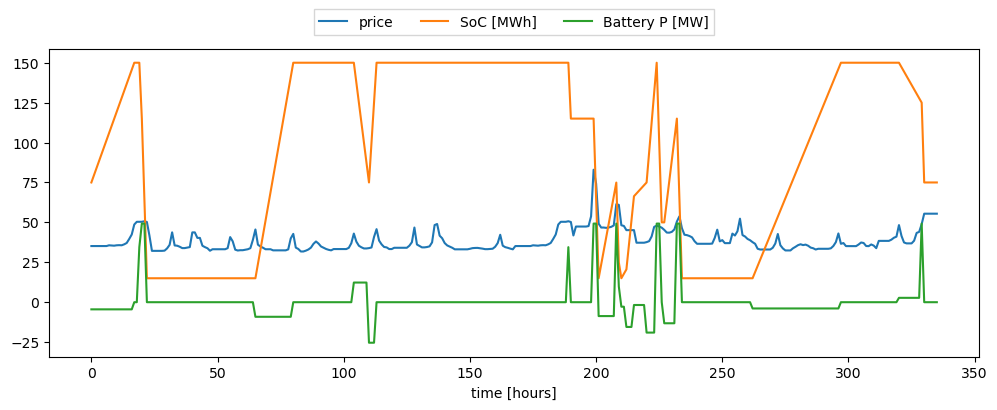

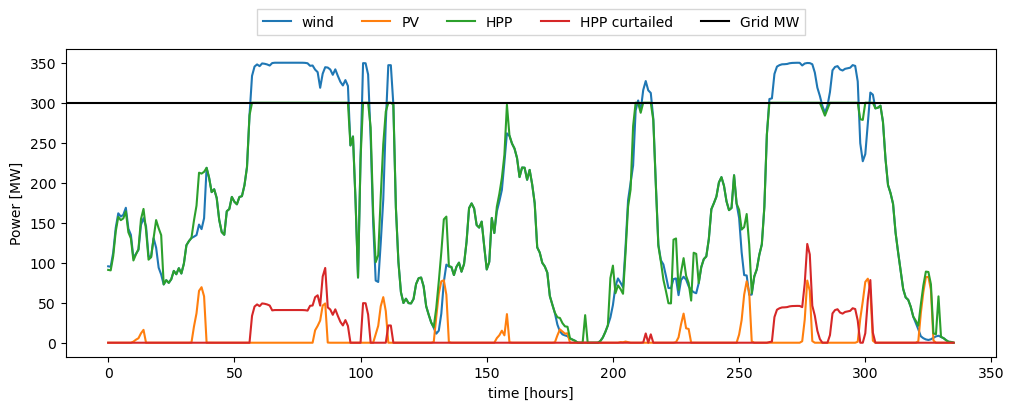

In [7]:
b_E_SOC_t = hpp.prob.get_val('ems.b_E_SOC_t')
b_t = hpp.prob.get_val('ems.b_t')
price_t = hpp.prob.get_val('ems.price_t')

wind_t = hpp.prob.get_val('ems.wind_t')
solar_t = hpp.prob.get_val('ems.solar_t')
hpp_t = hpp.prob.get_val('ems.hpp_t')
hpp_curt_t = hpp.prob.get_val('ems.hpp_curt_t')
grid_MW = hpp.prob.get_val('ems.G_MW')

n_days_plot = 14
plt.figure(figsize=[12,4])
plt.plot(price_t[:24*n_days_plot], label='price')
plt.plot(b_E_SOC_t[:24*n_days_plot], label='SoC [MWh]')
plt.plot(b_t[:24*n_days_plot], label='Battery P [MW]')
plt.xlabel('time [hours]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
           ncol=3, fancybox=0, shadow=0)

plt.figure(figsize=[12,4])
plt.plot(wind_t[:24*n_days_plot], label='wind')
plt.plot(solar_t[:24*n_days_plot], label='PV')
plt.plot(hpp_t[:24*n_days_plot], label='HPP')
plt.plot(hpp_curt_t[:24*n_days_plot], label='HPP curtailed')
plt.axhline(grid_MW, label='Grid MW', color='k')
plt.xlabel('time [hours]')
plt.ylabel('Power [MW]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
           ncol=5, fancybox=0, shadow=0)

In [8]:
results_1year = {'Electricity Price':price_t[:8760], 'Wind Power': wind_t[:8760],'Solar Power': solar_t[:8760],'HPP Power': hpp_t[:8760],'Curtailed Power': hpp_curt_t[:8760] ,'Battery SOC': b_E_SOC_t[:8760],'Battery Power': b_t[:8760]}
df = pd.DataFrame(results_1year)
df.to_csv('EMS_out.csv')

In [9]:
design_df = pd.DataFrame(columns = ['clearance [m]',
                                            'sp [W/m2]',
                                            'p_rated [MW]',
                                            'Nwt',
                                            'wind_MW_per_km2 [MW/km2]',
                                            'solar_MW [MW]',
                                            'surface_tilt [deg]',
                                            'surface_azimuth [deg]',
                                            'DC_AC_ratio',
                                            'b_P [MW]',
                                            'b_E_h [h]',
                                            'cost_of_battery_P_fluct_in_peak_price_ratio',
                                            'NPV_over_CAPEX',
                                            'NPV [MEuro]',
                                            'IRR',
                                            'LCOE [Euro/MWh]',
                                            'Revenues [MEuro]',
                                            'CAPEX [MEuro]',
                                            'OPEX [MEuro]',
                                            'Wind CAPEX [MEuro]',
                                            'Wind OPEX [MEuro]',
                                            'PV CAPEX [MEuro]',
                                            'PV OPEX [MEuro]',
                                            'Batt CAPEX [MEuro]',
                                            'Batt OPEX [MEuro]',
                                            'Shared CAPEX [MEuro]',
                                            'Shared OPEX [MEuro]',
                                            'penalty lifetime [MEuro]',
                                            'AEP [GWh]',
                                            'GUF',
                                            'grid [MW]',
                                            'wind [MW]',
                                            'solar [MW]',
                                            'Battery Energy [MWh]',
                                            'Battery Power [MW]',
                                            'Total curtailment [GWh]',
                                            'Total curtailment with deg [GWh]',
                                            'Awpp [km2]',
                                            'Apvp [km2]',
                                            'Plant area [km2]',
                                            'Rotor diam [m]',
                                            'Hub height [m]',
                                            'Number of batteries used in lifetime',
                                            'Break-even PPA price [Euro/MWh]',
                                            'Capacity factor wind [-]',
                                            'Execution time [min]',
                                            ]  , index=range(1))
design_df.iloc[0] =  list(x) + list(outs) + [(end - start)/60]
design_df = design_df.transpose()
design_df.to_csv('output.csv')